In [10]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("harjoitustyondata.csv", sep=";")
# Turning time into a datetime object
df['Aika'] = pd.to_datetime(df['Aika'], format='%d.%m.%Y %H:%M')

# Getting information about students
students = df.Pisteet.unique()
max_score =  max(students)
print(len(students), min(students), max(students))
course_start = df['Aika'].min()
course_end = df['Aika'].max()
print(course_start, course_end)

# To make things easier, let's collect the students into a dictionary, 
# where the points are the key to a list of all the student's timestamps
student_dict = {}
for student in students:
    student_info = df.loc[df['Pisteet'] == student]
    timestamp_list = student_info['Aika'].tolist()
    student_dict[student] = timestamp_list

score_student_mapping = {score: f"{idx+1}" for idx, score in enumerate(df['Pisteet'].unique())}
df['student_id'] = df['Pisteet'].map(score_student_mapping)

150 1055 7594
2019-08-07 10:15:00 2020-01-29 14:11:00


In [3]:
df

,Aika,Pisteet,student_id
0,2019-08-07 14:56:00,1055,1
1,2019-08-07 14:56:00,1055,1
2,2019-08-07 14:56:00,1055,1
3,2019-08-07 14:54:00,1055,1
4,2019-08-07 14:54:00,1055,1
...,...,...,...
6784,2019-10-14 12:48:00,7594,150
6785,2019-10-14 12:44:00,7594,150
6786,2019-10-14 12:44:00,7594,150
6787,2019-10-14 12:44:00,7594,150


Above we are sorting the data. The data is first turned into a Pandas DataFrame.
In the dataset, we have 150 different students, whose score range from 1055 points to 7594 points.
The first entry was 7.8.2019 and the last 29.1.2020, so we are assuming this is the duration of the course. 
This would mean that the course was active for about 6 months. 

Below we can see that the point distribution is a bit unusual. Most of the students collected very high scores. The median value is 6945, marked red in the graph below.

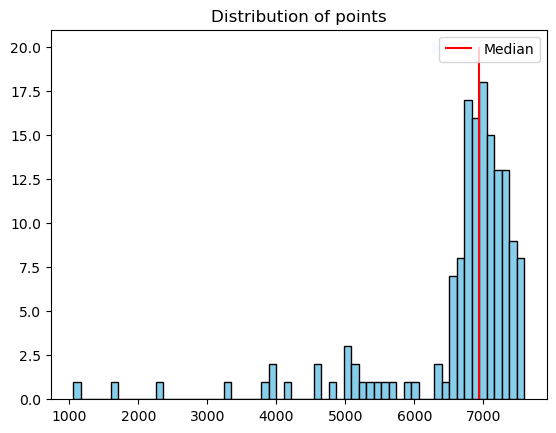

In [11]:
import statistics

median = statistics.median(students)

plt.hist(students, bins=60, color='skyblue', edgecolor='black')
plt.title('Distribution of points')
plt.vlines(x=median, ymin=0, ymax=20, color="red", label="Median")
plt.legend()
plt.show()

Based on this (and what G has done below), we can roughly divide the scores into three categories: 

* score < 6500
* 6500 < score < 7000
* score > 7000

Let's do some digging with the data, and see if we can come up with some rules(_or classifications? what they called_) for the decision tree thingaling 


# Hypothesis
- more active days &rarr; better score
- more logs &rarr; better score
- being consistently active &rarr; better score
- maybe the time of day spent working on the course has an effect on grades?



In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting data
# The time each student took to complete the course, rounded down
times = [(max(student_dict[s]) - min(student_dict[s])).total_seconds() / (60*60*24) + 1 for s in students]

# The number of different timestamps, i.e. the number of logs in total done by the student
logs = [len(student_dict[s]) for s in students]

# Finding out on how many different days a student worked on the course
dates = []
all_working_hours = [] #  time of day student tends to work, morning/day/night
pref_work_time = [] # 0 = morning, 1 = day, 2 = night
for s in students:  
    # Taking just the dates from timestamps, 
    # turning them into strings and to get only the unique values, turn the list into set
    uniq_dates = set([ str(d.date()) for d in student_dict[s]])
    # Append it as a list, 
    dates.append(len(uniq_dates)) 
    
    # Take the hour of the timesstamps and log it (morning: 6-12, day: 12-19, night: rest of the time)
    morning, day, night = 0, 0, 0
    hours = [(d.time().hour) for d in student_dict[s]]
    for hour in hours:
        if hour >= 6 and hour < 12:
            morning = morning + 1
        elif hour >= 12 and hour < 19:
            day = day + 1
        else: 
            night = night + 1
    # Here just collecting the data
    l = [morning, day, night]
    all_working_hours.append(l)
    # Finding out which index is the biggest to find out when student works the most
    # This is very inelegant, could be done better but let's see if there's something to it.
    m = max(l)
    pref_work_time.append(l.index(m))

In [13]:
# Here's a new dataframe for seaborn plotting.
# logs means the amount of logs,
# comp_t means the difference between last and first log, i.e. the course completion time
# log_days is the amount of days that logging has been done
# pref_work_t is the time of the day (morning, day, night) student has most time stamp logs
data = {"score": students, "logs": logs, "comp_t": times, "log_days":dates, "pref_work_t": pref_work_time }
df_new = pd.DataFrame(data)

In [14]:
df_new

,score,logs,comp_t,log_days,pref_work_t
0,1055,21,1.195139,1,1
1,1663,1,1.000000,1,2
2,2325,1,1.000000,1,0
3,3284,1,1.000000,1,0
4,3810,4,1.000000,1,1
...,...,...,...,...,...
145,7542,31,62.803472,6,2
146,7547,76,75.817361,7,1
147,7572,93,19.234028,7,2
148,7588,26,2.040972,2,2


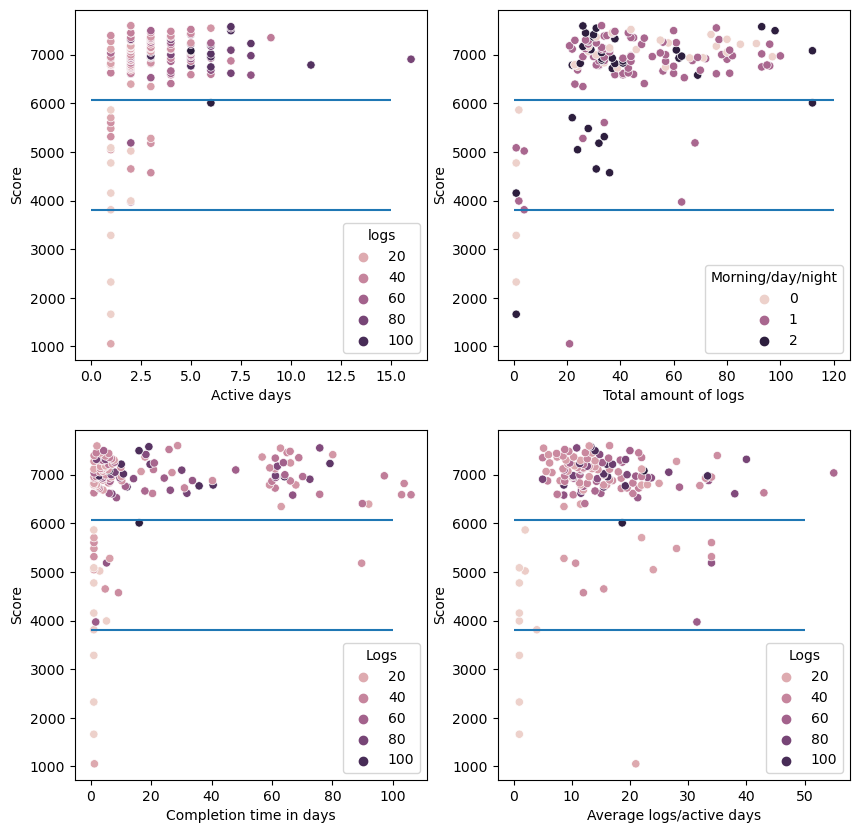

In [15]:
# Actual plotting 
import seaborn as sns

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))

times_arr = np.array(times) # course completion time
logs_arr = np.array(logs) # amount of logs
students_arr = np.array(students) # scores
dates_arr = np.array(dates) # active days

# for regression models
time_slope, time_intercept = np.polyfit(times_arr, students_arr, 1)
logs_slope, logs_intercept = np.polyfit(logs_arr, students_arr, 1)
dates_slope, dates_intercept = np.polyfit(dates_arr, students_arr, 1)

# Graph on top left
sns.scatterplot(x=dates_arr,
                y="score",
                hue="logs",
                ax=ax1,
                data=df_new)
ax1.hlines(y=max_score * 0.5, xmin=0, xmax=15)
ax1.hlines(y=max_score * 0.8, xmin=0, xmax=15)
ax1.set_xlabel('Active days')
ax1.set_ylabel('Score')

# Top right
sns.scatterplot(x="logs",
                    y="score",
                    hue="pref_work_t",
                    ax=ax2,
                    data=df_new)
ax2.hlines(y=max_score * 0.5, xmin=0, xmax=120)
ax2.hlines(y=max_score * 0.8, xmin=0, xmax=120)
ax2.set_ylabel('Score')
ax2.set_xlabel('Total amount of logs')
ax2.legend(title='Morning/day/night')


sns.scatterplot(x=times_arr,
                    y="score",
                    hue="logs",
                    ax=ax3,
                    data=df_new)
                    #, palette="Blues")
ax3.hlines(y=max_score * 0.5, xmin=0, xmax=100)
ax3.hlines(y=max_score * 0.8, xmin=0, xmax=100)
ax3.set_xlabel('Completion time in days')
ax3.set_ylabel('Score')
ax3.legend(title='Logs')
    
sns.scatterplot(x=logs_arr/dates_arr,
                    y="score",
                    hue="logs",
                    ax=ax4,
                    data=df_new)
                    #, palette="Blues")

ax4.hlines(y=max_score * 0.5, xmin=0, xmax=50)
ax4.hlines(y=max_score * 0.8, xmin=0, xmax=50)
ax4.set_xlabel('Average logs/active days')
ax4.set_ylabel('Score')
ax4.legend(title='Logs')

plt.show()

# Filtering
Here trying to filter the data a bit in order to make the algorithms predict scores better.
Removing from the database the students who completed the course with very high points (estimated grade 3 or above), since it seems unlikely that is possible in real life. Something hinky is going on there, so let's see what happens.

A very conservative reasoning for the numbers: let's assume this course is worth (at least) 1 credit, meaning an average student would take (at least) 27 hours of work, and let's say that amount of hours will get the student a grade 5. Let's be generous and assume the student can work 10 hours/day effectively, it would take about 2-3 days of active work to complete the course. (Here assuming most of the coursework happens within the LMS and therefore would leave a footprint of the action, i.e. a log.) Based on this it wouldn't be likely that the average student would get a high grade with less than 2-3 days of active work. Therefore, removing those entries that have gotten a score 3, 4 or 5 with only two days (or less) active work. 

Note: Not filtering out those who have gotten a low score with a couple active days, that seems more plausible. We do not wish to overfilter the data.

Before filtering, need to make the grade_category column

In [23]:
# Trying another way of categorizing, maybe will get better results?
def categorize_alternative(x):
    if x >= max_score * 0.9: # this would be a 5
        return 5
    elif x >= max_score * 0.8:
        return 4
    elif x >= max_score * 0.7:
        return 3
    elif x >= max_score * 0.6:
        return 2
    elif x >= max_score * 0.5:
        return 1
    else:
        return 0

# The grade based estimation is more precise than the divide into three same size units
# Here adding a new column for the score estimation categories
df_new['score_category'] = df_new['score'].apply(categorize_alternative)

df_new

,score,logs,comp_t,log_days,pref_work_t,score_category
0,1055,21,1.195139,1,1,0
1,1663,1,1.000000,1,2,0
2,2325,1,1.000000,1,0,0
3,3284,1,1.000000,1,0,0
4,3810,4,1.000000,1,1,1
...,...,...,...,...,...,...
145,7542,31,62.803472,6,2,5
146,7547,76,75.817361,7,1,5
147,7572,93,19.234028,7,2,5
148,7588,26,2.040972,2,2,5


In [26]:
# We wanna delete those who completed the course in one (active) day with a grade better than 3
df_filtered = df_new.query('not (log_days <= 2 and score_category >= 4)')
df_filtered

,score,logs,comp_t,log_days,pref_work_t,score_category
0,1055,21,1.195139,1,1,0
1,1663,1,1.000000,1,2,0
2,2325,1,1.000000,1,0,0
3,3284,1,1.000000,1,0,0
4,3810,4,1.000000,1,1,1
...,...,...,...,...,...,...
143,7490,98,15.972222,7,2,5
144,7515,44,25.914583,5,0,5
145,7542,31,62.803472,6,2,5
146,7547,76,75.817361,7,1,5


6956.5


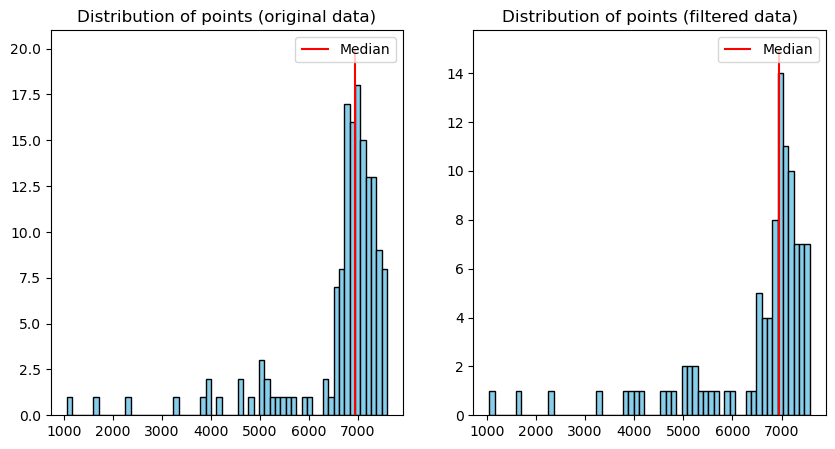

In [27]:
# Plotting old and new
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.hist(students, bins=60, color='skyblue', edgecolor='black')
ax1.set_title('Distribution of points (original data)')
ax1.vlines(x=median, ymin=0, ymax=20, color="red", label="Median")
ax1.legend()

students_filtered = df_filtered['score']
median_filtered_data = statistics.median(students_filtered)
print(median_filtered_data)
ax2.hist(students_filtered, bins=60, color='skyblue', edgecolor='black')
ax2.set_title('Distribution of points (filtered data)')
ax2.vlines(x=median, ymin=0, ymax=15, color="red", label="Median")
ax2.legend()
plt.show()

As can be seen, the size of the dataframe has reduced. Let's plot the points

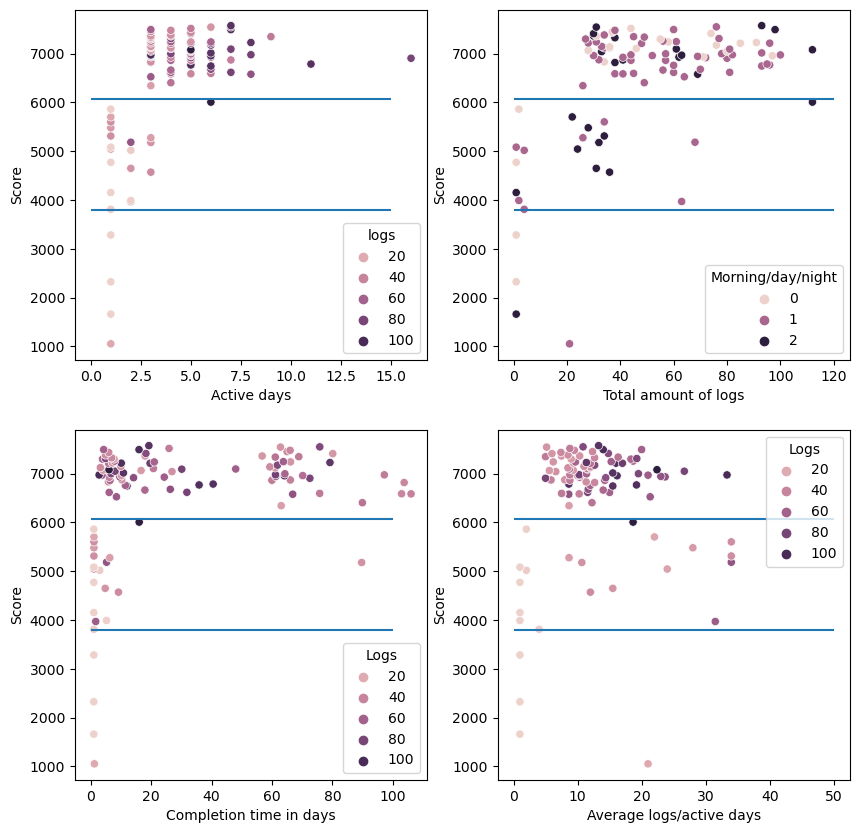

In [28]:
# Replotting 

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))

times_arr = df_filtered['comp_t'].to_numpy() # course completion time
logs_arr = df_filtered['logs'].to_numpy() # amount of logs
students_arr = df_filtered['score'].to_numpy() # scores
dates_arr = df_filtered['log_days'].to_numpy() # active days

# for regression models
time_slope, time_intercept = np.polyfit(times_arr, students_arr, 1)
logs_slope, logs_intercept = np.polyfit(logs_arr, students_arr, 1)
dates_slope, dates_intercept = np.polyfit(dates_arr, students_arr, 1)

# Graph on top left
sns.scatterplot(x=dates_arr,
                y="score",
                hue="logs",
                ax=ax1,
                data=df_filtered)
ax1.hlines(y=max_score * 0.5, xmin=0, xmax=15)
ax1.hlines(y=max_score * 0.8, xmin=0, xmax=15)
ax1.set_xlabel('Active days')
ax1.set_ylabel('Score')

# Top right
sns.scatterplot(x="logs",
                    y="score",
                    hue="pref_work_t",
                    ax=ax2,
                    data=df_filtered)
ax2.hlines(y=max_score * 0.5, xmin=0, xmax=120)
ax2.hlines(y=max_score * 0.8, xmin=0, xmax=120)
ax2.set_ylabel('Score')
ax2.set_xlabel('Total amount of logs')
ax2.legend(title='Morning/day/night')


sns.scatterplot(x=times_arr,
                    y="score",
                    hue="logs",
                    ax=ax3,
                    data=df_filtered)
                    #, palette="Blues")
ax3.hlines(y=max_score * 0.5, xmin=0, xmax=100)
ax3.hlines(y=max_score * 0.8, xmin=0, xmax=100)
ax3.set_xlabel('Completion time in days')
ax3.set_ylabel('Score')
ax3.legend(title='Logs')
    
sns.scatterplot(x=logs_arr/dates_arr,
                    y="score",
                    hue="logs",
                    ax=ax4,
                    data=df_filtered)
                    #, palette="Blues")

ax4.hlines(y=max_score * 0.5, xmin=0, xmax=50)
ax4.hlines(y=max_score * 0.8, xmin=0, xmax=50)
ax4.set_xlabel('Average logs/active days')
ax4.set_ylabel('Score')
ax4.legend(title='Logs')

plt.show()

# Things to input into the decision tree

Above on the top left we can see that most of the students got very high points, a lot of them in a relatively short time interval. Below some general rules
 * 4 or more active days &rarr; score at least 6500

On the top right, we can see that the amount of logs can vary a lot for the grade. More logs does not necessarily equal better grade. There is distinctin by color, 0 means students logs were mostly mornings, 1 means during daytime and 2 means during night. 
 * 20 logs or less &rarr; score below 6500
 * working mostly on mornings &rarr; score above 6500 (maybe even above 7000)

Bottom left we can see that almost all of the students completed the course with less than 10 days activity logged. If you put in more work, you will likely get a good score. 
* course completion time at least 20 days &rarr; grade probably above 6500
* lots of logs (80-100) &rarr; grade probably over 7000

Bottom right: average amount of logs per active days. 

Add to the database:
 * active days
 * preferred working time
 * amount of logs

Now, let's extract for each student ID: the score, the number of clicks that I have for each student and put all in a new dataset

In [ ]:
student_stats = df.groupby('student_id').agg(
    n_recordings=('Aika', 'count'),
    score=('Pisteet', 'first')
    ).reset_index()

student_stats = student_stats.rename(columns={'student_id': 'student_id', 'n_recordings': 'num_recordings', 'score': 'score'})

print(student_stats)

We can define the classes for the score, chosen in a way that each class has a relevant number of entries.

In [ ]:
plt.figure(figsize=(10, 6))

plt.scatter(student_stats['student_id'], student_stats['score'], color='red', label='Scores')

plt.title('Scores')
plt.xlabel('Student ID')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


We can divide the scores in 3 categories:

* score < 6500
* 6500 < score < 7000
* score > 7000

In [ ]:
print(student_stats[student_stats['score'] < 6500]['student_id'].nunique())
print(student_stats[(student_stats['score'] >= 6500) & (student_stats['score'] <= 7000)]['student_id'].nunique())
print(student_stats[student_stats['score'] > 7000]['student_id'].nunique())

In [ ]:
plt.figure(figsize=(10, 6))

plt.scatter(student_stats['score'], student_stats['num_recordings'], color='red', label='Scores')

plt.title('Scores vs Number of Records')
plt.xlabel('Score')
plt.ylabel('Number of Records')
plt.legend()
plt.grid(True)
plt.show()

Now, we want to predict the score class based on the number of clicks and the mean click time. In a decision tree, each node tells to which sub tree the input sample should move until the sub tree is only the leaf node that corresponds to some class.

In [ ]:
# The following is done based on the information found on the page
# https://www.datacamp.com/tutorial/decision-tree-classification-python 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
from sklearn import metrics 

# print(df_new) # Using this for starters with the decision tree

# Need to adjust the scoring category --> divide it to three
# score less than 6500 --> 0
# score between 6500 and 7000 --> 1
# score above 7000 --> 2
def categorize(x):
    if x < 6500:
        return 0
    elif x >= 7000:
        return 2
    else:
        return 1

# Moved all this higher up, score_category used earlier and it's a bitch after restarting the kernel when it's not "yet defined"
# Trying another way of categorizing, maybe will get better results?
# def categorize_alternative(x):
#    if x < max_score * 0.5: # rough estimate, below this the grade is 0
#         return 0
#     elif x >= max_score * 0.9: # this would be a good grade
#         return 5
#     elif x >= max_score * 0.8:
#         return 4
#     elif x >= max_score * 0.7:
#         return 3
#     elif x >= max_score * 0.6:
#         return 2
#     else:
#         return 1 

# The grade based estimation is more precise than the divide into three same size units
# Here adding a new column for the score estimation categories
# df_new['score_category'] = df_new['score'].apply(categorize_alternative)
# df_new['score_category'] = df_new['score'].apply(categorize)
# df_filtered['score_category'] = df_filtered['score'].apply(categorize_alternative)

# print(df_new)
print(df_filtered)
#split dataset in features and target variable
feature_cols = ['logs', 'comp_t', 'log_days', 'pref_work_t' ]
X = df_filtered[feature_cols] # Features
y = df_filtered.score_category # Target variable

# Split dataset into training set and test set
# 75% training, 25% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1) 

max_leaf_nodes = 10
min_sample_leaf = 10
max_depth = 4  # Keeping the depth small seems to lead to better results

clf = DecisionTreeClassifier(criterion="gini", 
                             max_leaf_nodes = max_leaf_nodes,
                             min_samples_leaf = min_sample_leaf, 
                             max_depth= max_depth)

clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# TODO: Still should visualize maybe


In [ ]:
!pip install pydotplus

In [ ]:
!pip install pydotplus
!pip install graphviz
# Might have to go to your environment variables and add the graphviz binaries directory there. Not sure how your system is 
# configured, hope it works :D Remember to restart the kernel, that tripped me up

In [ ]:
import graphviz

In [ ]:
from six import StringIO 
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1', '2', '3', '4', '5'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('tree.png')
Image(graph.create_png())

 [maybe we can write something like you write:] Looks like we can only determine the the difference between grades 2, 5 and 4. That's not surprising, because the data was so tightly packed in the higher scores and most of the students got scores that would give out a grade 5.
 
 Only a few people "failed" the course, so they wouldn't even be seen as a leaf node because right now the minimum sample in the leaf is set to 10.

\+ important stuff: we have an accuracy of 0.5 that is not that good

\+ with the filtered data, accuracy is way better, 0.72



In [ ]:
feature_cols = ['logs', 'comp_t', 'log_days', 'pref_work_t' ]
X = df_new[feature_cols] # Features
y = df_new.score_category # Target variable


X = df_filtered[feature_cols] # Features
y = df_filtered.score_category # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 

max_leaf_nodes = 10
min_sample_leaf = 10
max_depth = 3 # Keeping the depth small seems to lead to better results

clf = DecisionTreeClassifier(criterion="gini", 
                             max_leaf_nodes = max_leaf_nodes,
                             min_samples_leaf = min_sample_leaf, 
                             max_depth= max_depth)

clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1', '2', '3', '4', '5'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('tree.png')
Image(graph.create_png())

In [ ]:
df_new

In [ ]:
df_new

A bit of preprocessing

In [ ]:
# DATA PREPROCESSING

# feature scaling - standardization

from sklearn.preprocessing import StandardScaler

def standardize_columns(df, columns):
    scaler = StandardScaler()
    df_std = df.copy()
    df_std[columns] = scaler.fit_transform(df_std[columns])
    
    return df_std

df_standardized = standardize_columns(df_new, ['logs', 'comp_t', 'log_days', 'pref_work_t'])

In [ ]:
df_standardized

In [ ]:
class_distribution=df_standardized['score_category'].value_counts().sort_index()
print(class_distribution)

In [ ]:
# Class distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
class_distribution.plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Score Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

We have unbalanced classes: accuracy is not the best metric! 


In [ ]:
pip install imbalanced-learn scikit-learn

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

feature_cols = ['logs', 'comp_t', 'log_days', 'pref_work_t' ]
X = df_standardized[feature_cols]
y = df_standardized.score_category 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(k_neighbors=2, sampling_strategy='minority',
               random_state=42) # oversampling

# oversampling of the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
max_leaf_nodes = 10
min_sample_leaf = int(0.05*len(df_standardized))
max_depth = 4

clf = DecisionTreeClassifier(criterion="log_loss", 
                             max_leaf_nodes = max_leaf_nodes,
                             min_samples_leaf = min_sample_leaf, 
                             max_depth= max_depth)

clf.fit(X_train_resampled, y_train_resampled)

y_pred = clf.predict(X_test)

In [ ]:
# evaluation metric: F1-score
f1 = f1_score(y_test, y_pred, average='micro')
print("F1-score:", f1)

F1-score is harmonic mean of precision and recall and ranges from 0 to 1, where: 0 indicates poor performance and 1 indicates perfect performance.

F1 scores closer to 1 are desirable, indicating a model with high precision and recall.

In [ ]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0', '1', '2', '3', '4', '5'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('tree.png')
Image(graph.create_png())

Let's try with three classes at this point ...

In [ ]:
data = {"score": students, "logs": logs, "comp_t": times, "log_days":dates, "pref_work_t": pref_work_time }
df_new = pd.DataFrame(data)

def categorize_alternative2(x):
    if x >= max_score * 0.9:
        return 3
    elif x >= max_score * 0.75:
        return 2
    elif x >= max_score * 0.5:
        return 1
    else:
        return 0

df_new['score_category'] = df_new['score'].apply(categorize_alternative2)

print(df_new)

In [ ]:
class_distribution=df_standardized['score_category'].value_counts().sort_index()
print(class_distribution)

still unbalanced

In [ ]:
# Class distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
class_distribution.plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Score Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

def standardize_columns(df, columns):
    scaler = StandardScaler()
    df_std = df.copy()
    df_std[columns] = scaler.fit_transform(df_std[columns])
    
    return df_std

df_standardized = standardize_columns(df_new, ['logs', 'comp_t', 'log_days', 'pref_work_t'])

In [ ]:
df_standardized

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

feature_cols = ['logs', 'comp_t', 'log_days', 'pref_work_t' ]
X = df_standardized[feature_cols]
y = df_standardized.score_category 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

smote = SMOTE(k_neighbors=2, sampling_strategy='minority',
               random_state=42) # oversampling

# oversampling of the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
# HYPERPARAMETER TUNING
from sklearn.metrics import make_scorer, log_loss
from sklearn.model_selection import GridSearchCV

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_leaf_nodes': [5, 10, 15, 20, 35],
    'min_samples_leaf': [int(0.01 * len(X_train)), int(0.05 * len(X_train)), int(0.1 * len(X_train))],
    'max_depth': [10, 15, 20, 25]
}

scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, scoring=scorer)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

In [ ]:
max_leaf_nodes = best_params['max_leaf_nodes']
min_sample_leaf = best_params['min_samples_leaf']
max_depth = best_params['max_depth']

clf = DecisionTreeClassifier(criterion=best_params['criterion'], 
                             max_leaf_nodes = max_leaf_nodes,
                             min_samples_leaf = min_sample_leaf, 
                             max_depth= max_depth)

clf.fit(X_train_resampled, y_train_resampled)

y_pred = clf.predict(X_test)

In [ ]:
# evaluation metric: F1-score
f1 = f1_score(y_test, y_pred, average='micro')
print("F1-score:", f1)

In [ ]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0', '1', '2', '3'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('tree.png')
Image(graph.create_png())

I saw in methods that is a good idea to make a comparison between two different models... Maybe I'll try here to fit a linear regression and see what happens...

In [ ]:
import statsmodels.formula.api as smf

model = smf.ols('score ~ logs + comp_t + log_days + pref_work_t', data=df_new).fit()

print(model.summary())


OK
R-squared: 0.168 is terrible, because it represents the proportion of the variance in the dependent variable that is explained by the independent variables in the model (goodness of fit of the model to the data) -> with this model we are explaining just the 16.8% of the variance.
The remaining 83.2% of the variability is unexplained by the model and could be due to other factors not considered in the model or random variability.

To identify the significant coefficients: we have to look at small values of P>|t|. Therefore, logs is the only significant feature in this model (maybe we can also consider comp_t...)

In [ ]:
model = smf.gls('score ~ logs + comp_t', data=df_new).fit()

print(model.summary())

logs+comp_t explained 16.3% of the variance: these two features are the only ones that are significant

In [ ]:
model = smf.gls('score ~ logs', data=df_new).fit()

print(model.summary())

Just using logs we explained 14.6% of the variance. It's anyway a bad model but at least it's simple lol

Another variable that we could consider: the duration between timestamps

In [ ]:
df

In [ ]:
df1 = df
df1.sort_values(by=['student_id', 'Aika'], inplace=True)

In [ ]:
total_durations = {}
k=0
for student_id, group in df.groupby('student_id'):
    total_duration = group['Aika'].diff().sum()
    total_durations[student_id] = total_duration.total_seconds()
total_durations

In [ ]:
timestamp_counts = df['student_id'].value_counts()
timestamp_counts

In [ ]:
df_merged = pd.DataFrame({'total_duration': total_durations, 'timestamp_count': timestamp_counts})
df_merged.index = df_merged.index.astype(int)
df_merged['average_duration'] = df_merged['total_duration'] / df_merged['timestamp_count']

df_merged=df_merged.sort_index()
df_merged


In [ ]:
data = {"score": students, "logs": logs, "comp_t": times, "log_days":dates, "pref_work_t": pref_work_time, 'average_duration': df_merged['average_duration']}
df_new3 = pd.DataFrame(data)
df_new3

In [ ]:
model = smf.gls('score ~ logs + comp_t + log_days + pref_work_t + average_duration', data=df_new3).fit()

print(model.summary())

In [ ]:
model = smf.gls('score ~ logs + comp_t + average_duration', data=df_new3).fit()

print(model.summary())

rip

if you have some other ideas of feature that we can try to extract let me know hahah